# Imports

In [1]:
import numpy as np
from scipy.stats import ttest_ind

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR, 
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)
from khan_helpers.functions import reconstruct_trace

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def format_stats(stat, p, stat_name, df=None):
    stat_fmt = fr'${stat_name}$'
    if df is not None:
        stat_fmt = f'{stat_fmt}({df})'
    
    stat_fmt = f'{stat_fmt} = {stat:.3f}\n$p$'
    if p < 0.001:
        p_fmt = ' < 0.001'
    else:
        p_fmt = f' = {p:.3f}'
    
    return f'{stat_fmt}{p_fmt}'

# Estimate knowledge for held-out question

In [3]:
exp = Experiment()

In [4]:
knowledge_estimates = {}
for quiz in range(1, 4):
    correct_knowledge_estimates = []
    incorrect_knowledge_estimates = []

    for p in exp.participants:
        quiz_data = p.get_data(quiz=quiz-1)
        
        for ix, heldout_question_data in enumerate(quiz_data.itertuples()):
            if heldout_question_data.qID == 38:
                continue
            
            other_questions_data = quiz_data.drop(index=heldout_question_data.Index)
            heldout_question = exp.question_vectors[heldout_question_data.qID - 1]
            other_questions = exp.question_vectors[other_questions_data['qID'] - 1]
            accuracy = other_questions_data['accuracy']
            knowledge_estimate = reconstruct_trace(heldout_question[None, :], 
                                                   other_questions, 
                                                   accuracy).item()
            if heldout_question_data.accuracy == 1:
                correct_knowledge_estimates.append(knowledge_estimate)
            else:
                incorrect_knowledge_estimates.append(knowledge_estimate)

    knowledge_estimates[f'quiz{quiz}'] = {
        'correct': correct_knowledge_estimates, 
        'incorrect': incorrect_knowledge_estimates
    }

# Construct and display figure

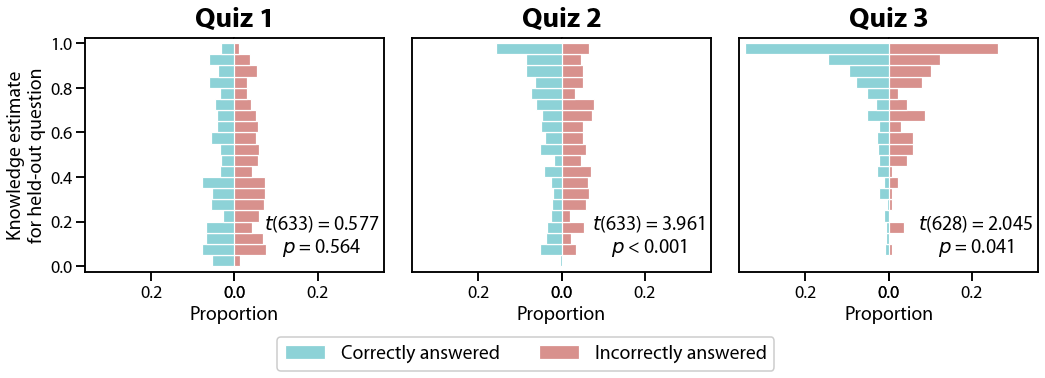

In [5]:
with sns.plotting_context('talk', font_scale=1.1):
    fig = plt.figure(figsize=(15, 5))
    main_gs = fig.add_gridspec(1, 3)

    quiz1_gs = main_gs[0].subgridspec(1, 2, wspace=0)
    quiz2_gs = main_gs[1].subgridspec(1, 2, wspace=0)
    quiz3_gs = main_gs[2].subgridspec(1, 2, wspace=0)
    
    ax1 = fig.add_subplot(quiz1_gs[0])
    ax2 = fig.add_subplot(quiz1_gs[1], sharey=ax1)
    ax3 = fig.add_subplot(quiz2_gs[0], sharey=ax1)
    ax4 = fig.add_subplot(quiz2_gs[1], sharey=ax1)
    ax5 = fig.add_subplot(quiz3_gs[0], sharey=ax1)
    ax6 = fig.add_subplot(quiz3_gs[1], sharey=ax1)
    
    axarr = np.array((ax1, ax2, ax3, ax4, ax5, ax6))
    bins = np.linspace(0, 1, 21, endpoint=True, dtype=np.float16)
    
    for quiz, (left_ax, right_ax) in enumerate(axarr.reshape(3, 2), start=1):
        quiz_estimates = knowledge_estimates[f'quiz{quiz}']
        correct_estimates = quiz_estimates['correct']
        incorrect_estimates = quiz_estimates['incorrect']
        
        t, p = ttest_ind(correct_estimates, incorrect_estimates)
        deg_freedom = len(correct_estimates) + len(incorrect_estimates) - 2
        
        sns.histplot(y=correct_estimates, 
                     bins=bins,
                     stat='proportion',
                     color=CORRECT_ANSWER_COLOR,
                     edgecolor='white',
                     ax=left_ax, label='correct')
        sns.histplot(y=incorrect_estimates, 
                     bins=bins,
                     stat='proportion',
                     color=INCORRECT_ANSWER_COLOR,
                     edgecolor='white',
                     ax=right_ax, label='incorrect')
        
        left_ax.set_xlim(0, 0.36)
        right_ax.set_xlim(0, 0.36)
        
        left_ax.set_title(f'Quiz {quiz}', 
                          x=1,
                          y=1.02, 
                          fontsize='x-large', 
                          fontweight='bold')
        
        left_ax.set_xlabel('Proportion', x=1, ha='center')
        right_ax.set_xlabel(None)
        
        left_ax.invert_xaxis()
        
        right_ax.annotate(format_stats(t, p, 't', deg_freedom), 
                          xy=(0.21, 0.06), 
                          fontsize='medium',
                          ha='center')

        left_ax.spines['right'].set_visible(False)
        right_ax.spines['left'].set_visible(False)
        
    ax1.set_ylim(-0.025, 1.025)
    ax1.set_ylabel('Knowledge estimate\nfor held-out question')
    
    for ax in axarr[1:]:
        ax.tick_params(left=False, labelleft=False)
    
    fig.legend((ax1.containers[0], ax2.containers[0]), 
               ('Correctly answered', 'Incorrectly answered'), 
               loc='lower center', 
               ncol=2, 
               fontsize='medium',
               framealpha=1, 
               bbox_to_anchor=(0.5, -0.1))
        
    plt.tight_layout()
#     plt.savefig(FIG_DIR.joinpath('held-out-question-analysis.pdf'), bbox_inches='tight')
    plt.show()